# NB to investigate orientation estimations

In [1]:
from functions.pitch_analysis import *
from functions.zurich_move_data_extraction import extract_sensors_data_from_axivity_file
from functions.VQFpitch import IMUPitchCalculator

### iPhone

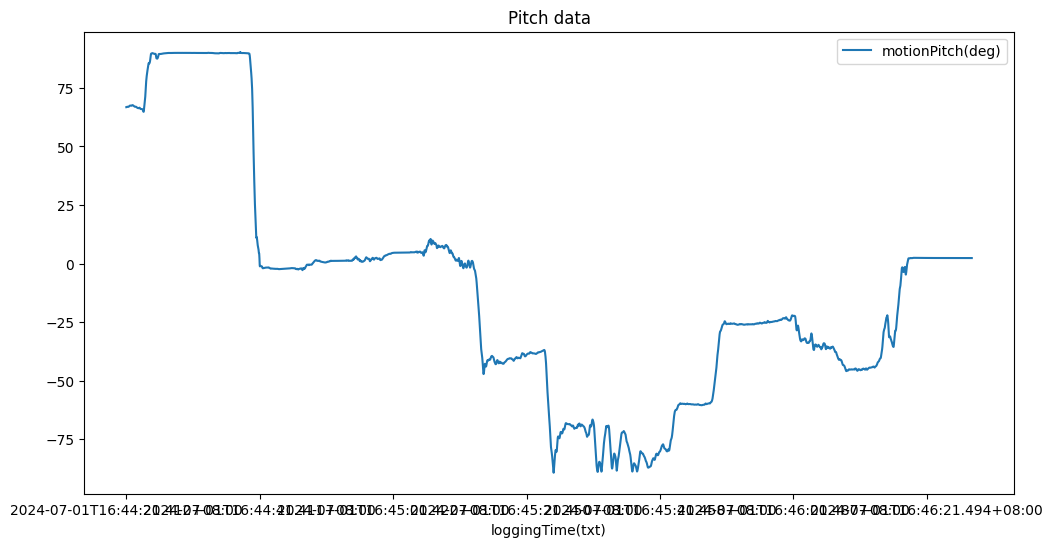

In [2]:
iphone_pitch = read_pitch_from_csv('../data/pitch_analysis/2024-07-01_16_44_21_my_iOS_device 2024-07-01 08_51_15.csv')
plot_pitch_data(iphone_pitch)

### Axivity

In [3]:
sensor_features = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
LW_data = extract_sensors_data_from_axivity_file('../data/pitch_analysis/6023695_0000000999.resampled.csv', sensor_features)
RW_data = extract_sensors_data_from_axivity_file('../data/pitch_analysis/6022607_0000000999.resampled.csv', sensor_features)
acc_LW = LW_data[['acc_x', 'acc_y', 'acc_z']]
acc_RW = RW_data[['acc_x', 'acc_y', 'acc_z']]
gyro_LW = LW_data[['gyro_x', 'gyro_y', 'gyro_z']]
gyro_RW = RW_data[['gyro_x', 'gyro_y', 'gyro_z']]
sampling_freq = 50 # Hz

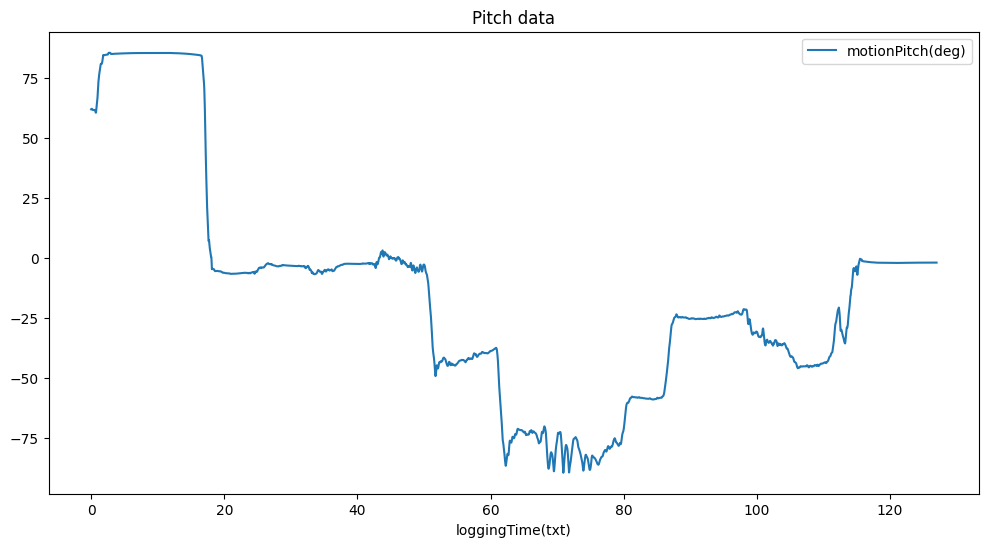

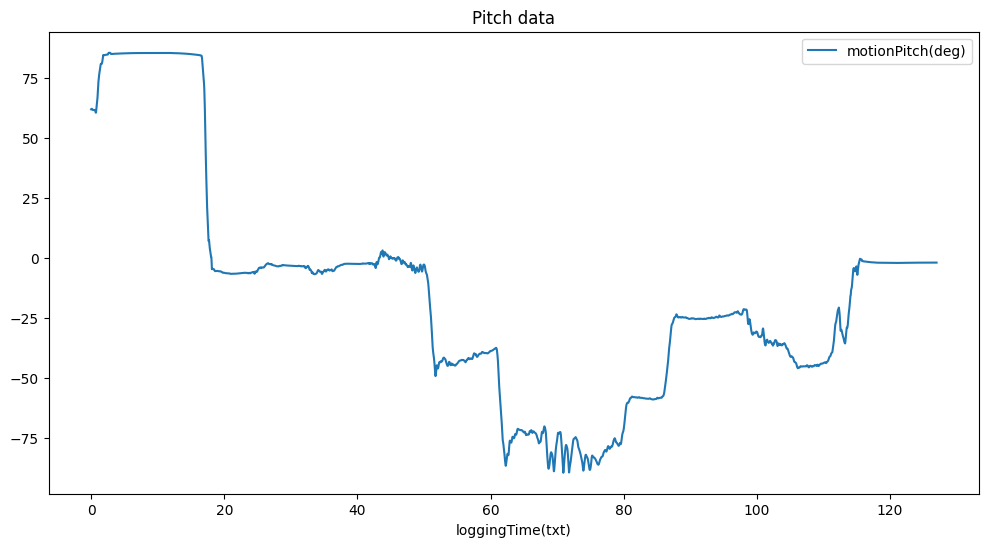

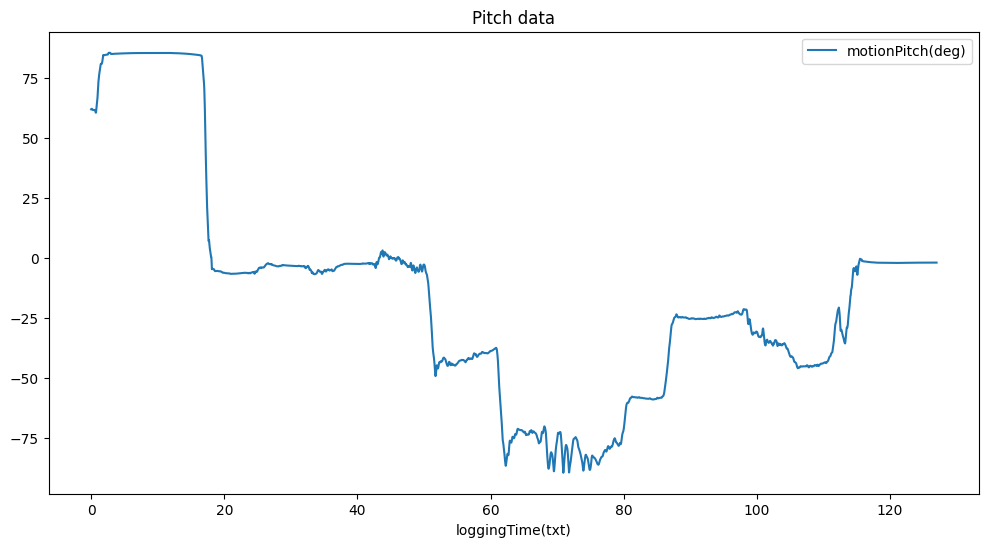

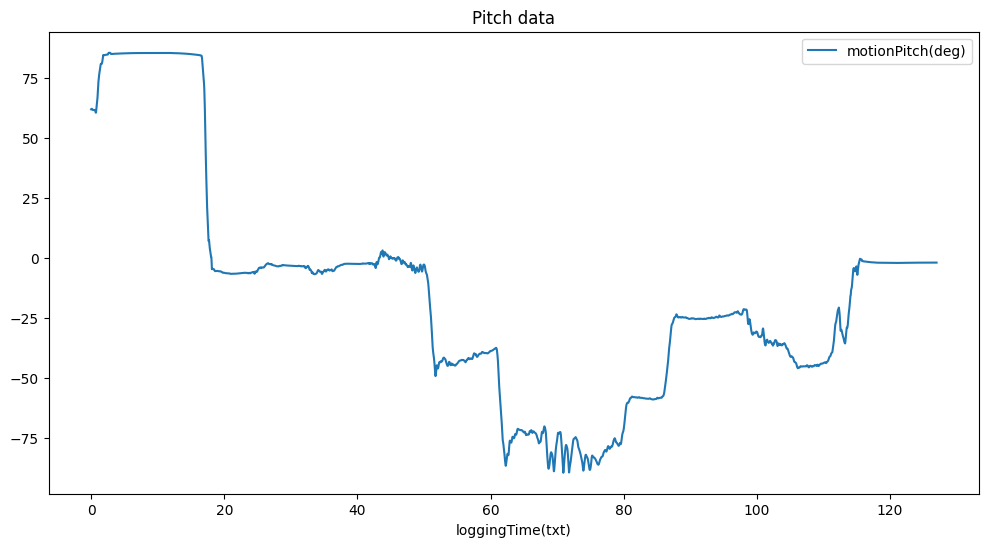

In [4]:
calculator_LW = IMUPitchCalculator(acc_LW.to_numpy().copy(), gyro_LW.to_numpy().copy(), sampling_freq)
pitch_VQF_LW = calculator_LW.calculate_pitch()
elevation_VQF_LW = calculator_LW.calculate_elevation()
calculator_LW.cut_recording(27*50, 154*50)
calculator_LW.plot_pitch(calculator_LW.pitch)
calculator_LW.plot_pitch(calculator_LW.elevation)
calculator_RW = IMUPitchCalculator(acc_RW.to_numpy().copy(), gyro_RW.to_numpy().copy(), sampling_freq)
pitch_VQF_RW = calculator_RW.calculate_pitch()
elevation_VQF_RW = calculator_RW.calculate_elevation()
calculator_RW.cut_recording(47*50, 174*50)
calculator_RW.plot_pitch(calculator_LW.pitch)
calculator_RW.plot_pitch(calculator_LW.elevation)

## Gravitation compensation

In [5]:
from ahrs.filters import Madgwick
from ahrs.common import orientation
from functions.VQFpitch import IMUPitchCalculator, vqf_gravitation_compensation
from scipy.spatial.transform import Rotation as R

In [6]:
def Subash_gravitation_compensation(acc, gyr):
    # Constants for conversions
    g_to_m_s2 = 9.80665  # 1 g = 9.80665 m/s^2
    deg_to_rad = np.pi / 180  # 1 degree = π/180 radians
        
    # Extract and convert acceleration and gyroscope data
    acc = acc * g_to_m_s2
    gyr = gyr * deg_to_rad
    g = np.array([0, 0, g_to_m_s2])
    ae = np.empty([len(acc), 3])

    mg = Madgwick(frequency=50, beta=0.5)
    q = np.tile([1., 0., 0., 0.], (len(acc), 1))

    r = orientation.q2R(mg.updateIMU(q[0], gyr[0], acc[0]))
    ae[0] = np.matmul(r, acc[0]) - g

    for i in range(1, len(acc)):
        q[i] = mg.updateIMU(q[i - 1], gyr[i], acc[i])
        r = orientation.q2R(q[i])
        ae[i] = np.matmul(r, acc[i]) - g
    return ae/g_to_m_s2

In [7]:
gyr = np.array(gyro_LW)
acc = np.array(acc_LW)

acceleration_without_gravity = Subash_gravitation_compensation(acc, gyr)

<Axes: >

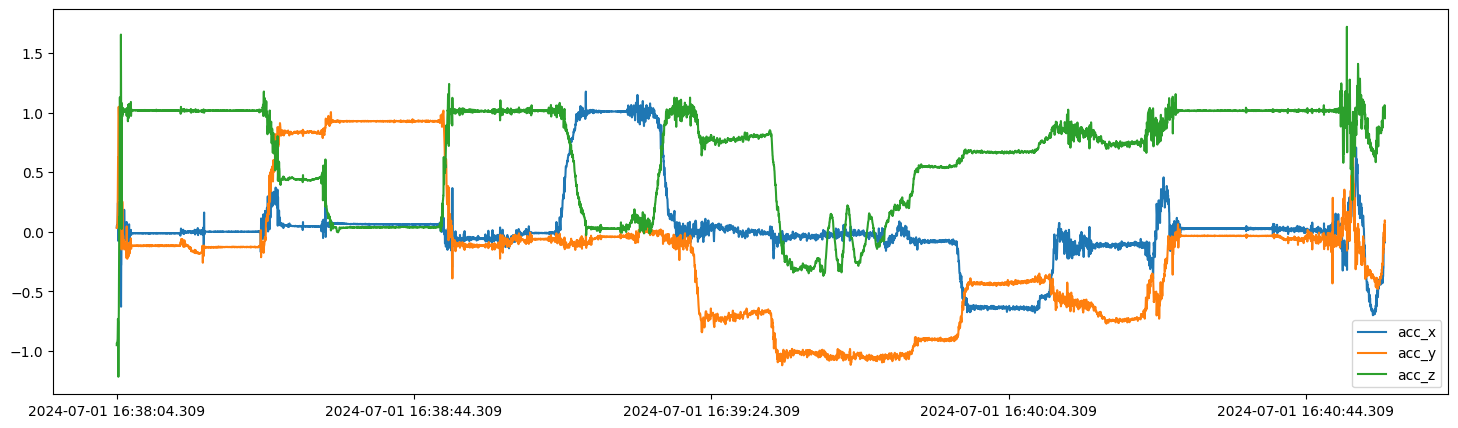

In [8]:
acc_LW.plot(figsize=(18, 5))
#acc_RW.plot()

<Axes: >

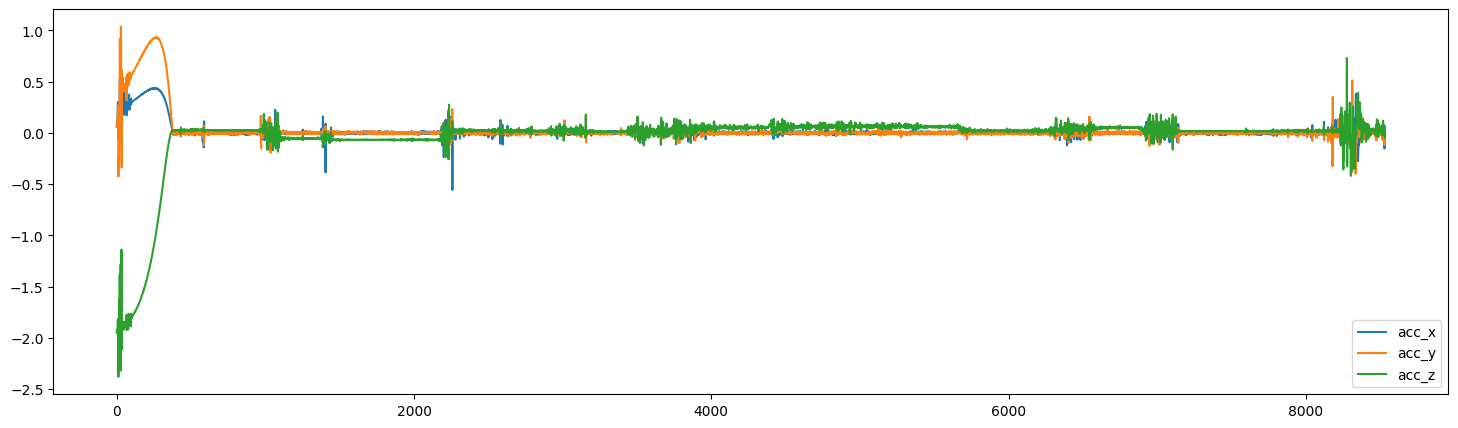

In [9]:
acceleration_without_gravity = pd.DataFrame(acceleration_without_gravity, columns=['acc_x', 'acc_y', 'acc_z'])
acceleration_without_gravity.plot(figsize=(18, 5))

<Axes: >

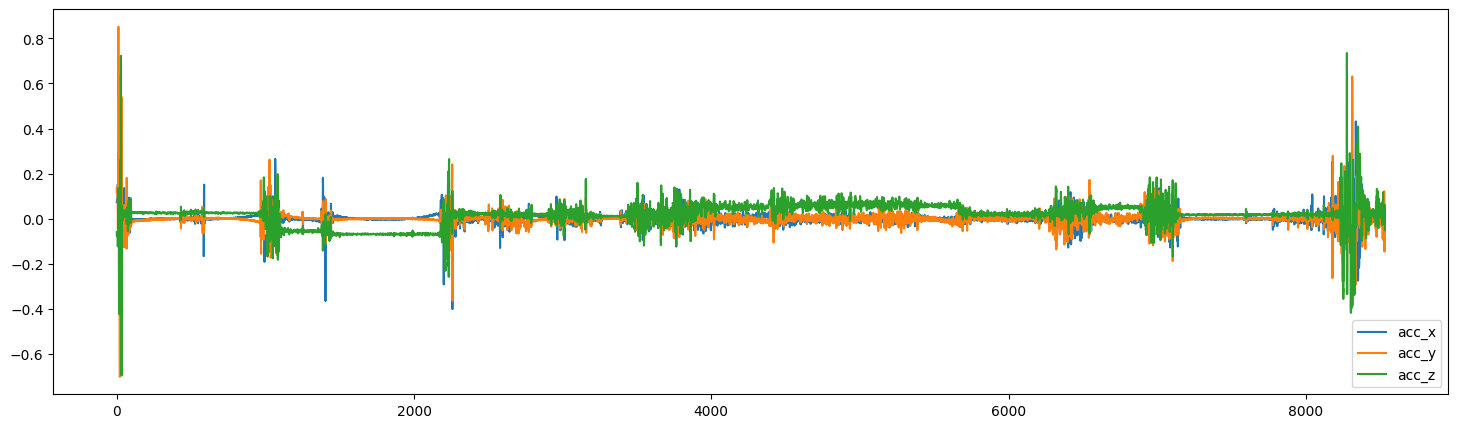

In [10]:
acc_vqf_compensation = vqf_gravitation_compensation(acc.copy(), gyr.copy())
acc_vqf_compensation = pd.DataFrame(acc_vqf_compensation, columns=['acc_x', 'acc_y', 'acc_z'])
acc_vqf_compensation.plot(figsize=(18, 5))